In [16]:
%matplotlib notebook
import matplotlib.pyplot as plt
import optax

from cc.collect import *
from cc import save, load
from cc.controller import create_pi_controller, LinearController, LinearControllerOptions
from cc.env.model_based_env import ModelBasedEnv
from cc.env.wrappers import AddReferenceObservationWrapper, RecordVideoWrapper
from cc.env import make_env
from cc.train import TrainingOptionsController, train_controller
from cc.utils.utils import generate_ts, extract_timelimit_timestep_from_env

import pprint
import numpy

In [17]:
time_limit = 10.0
control_timestep = 0.01
ts = generate_ts(time_limit, control_timestep)

# Environment creation
env = make_env("two_segments_v1", random=1, time_limit=time_limit,
               control_timestep=control_timestep)

# Model Loading
model = load("../docs/model_for_two_segments_v1.pkl")
source = collect_reference_source(
    env, seeds=[20], constant_after=True, constant_after_T=3.0)

In [18]:
def get_controller(p_gain = 0.01, i_gain = 0.0):
    # Training
    options = create_pi_controller(p_gain, i_gain, delta_t=control_timestep)
    controller = LinearController(options)

    training_options = TrainingOptionsController(
        optax.adam(3e-3), 0.0, 500, 1, models=[model]
    )

    controller, losses = train_controller(controller, source, training_options)
    return controller, f"p_gain: {p_gain} i_gain: {i_gain}"

In [19]:
controllers = []
controllers.append(get_controller())

pp = pprint.PrettyPrinter(indent=4)
numpy.set_printoptions(threshold=5)


Trainings-Loss:    16.0842 | ParamsRegu:     0.0051: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 142.44it/s]


In [20]:
for p in range(60, 80, 2):
    for i in range(0, 20, 2):
        controllers.append(get_controller(p / 100, i / 100))

Trainings-Loss:     2.1253 | ParamsRegu:     1.0209: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 141.49it/s]
Trainings-Loss:     2.2346 | ParamsRegu:     0.9690: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 144.69it/s]
Trainings-Loss:     2.3595 | ParamsRegu:     0.9150: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 139.30it/s]
Trainings-Loss:     2.4929 | ParamsRegu:     0.8630: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 140.19it/s]
Trainings-Loss:     2.6286 | ParamsRegu:     0.8152: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 137.52it/s]
Trainings-Loss:     2.7622 | ParamsRegu:     0.7724: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 138.62it/s]
Trainings-Loss: 

Trainings-Loss:     2.7088 | ParamsRegu:     0.7888: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 146.53it/s]
Trainings-Loss:     1.7727 | ParamsRegu:     1.2287: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 140.58it/s]
Trainings-Loss:     1.8511 | ParamsRegu:     1.1764: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 146.00it/s]
Trainings-Loss:     1.9398 | ParamsRegu:     1.1217: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 148.46it/s]
Trainings-Loss:     2.0354 | ParamsRegu:     1.0677: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 144.96it/s]
Trainings-Loss:     2.1352 | ParamsRegu:     1.0161: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 140.93it/s]
Trainings-Loss: 

Trainings-Loss:     2.2389 | ParamsRegu:     0.9665: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 135.98it/s]
Trainings-Loss:     2.3085 | ParamsRegu:     0.9358: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 141.43it/s]


In [23]:
time_limit, control_timestep, ts = extract_timelimit_timestep_from_env(env)

#real_env_w_source = ModelBasedEnv(env, model, time_limit=time_limit, control_timestep=control_timestep) # <--- collect 
env_with_ref = AddReferenceObservationWrapper(env, source)
result = collect_multiple(env, source, [c[0] for c in controllers])

result_ranked = sorted(enumerate(result.obs["obs"]["xpos_of_segment_end"]), key=lambda x: result.extras["aggr_rew"][x[0]])


<IPython.core.display.Javascript object>


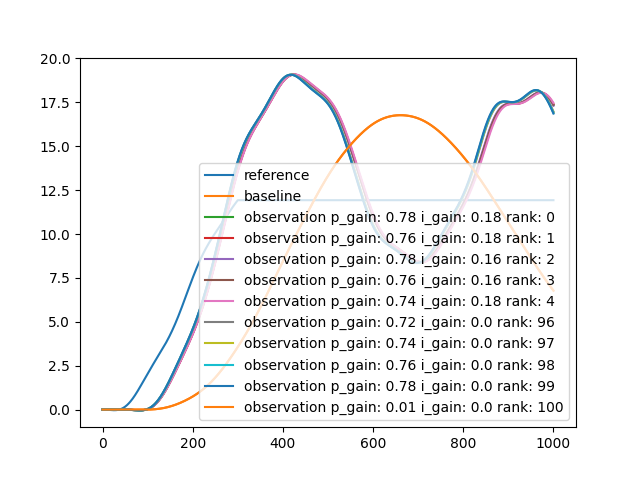

18697.066
0: 15159.4306640625
1: 15170.33203125
2: 15172.4921875
3: 15183.017578125
4: 15183.1904296875
0: 15310.5107421875
1: 15314.7490234375
2: 15317.166015625
3: 15318.197265625
4: 18697.06640625


In [29]:
plt.plot(result.obs["ref"]
         ["xpos_of_segment_end"][0], label="reference")
plt.plot(result.obs["obs"]
         ["xpos_of_segment_end"][0], label="baseline")
print(numpy.sum(numpy.abs(result.extras["aggr_rew"][0])))

for rank, (index, value) in enumerate(result_ranked[:5]):
    print(f"{rank}: {result.extras['aggr_rew'][index]}")
    plt.plot(value, label=f"observation {controllers[index][1]} rank: {rank}")

for rank, (index, value) in enumerate(result_ranked[-5:]):
    print(f"{rank}: {result.extras['aggr_rew'][index]}")
    plt.plot(value, label=f"observation {controllers[index][1]} rank: {len(result_ranked) - 5 + rank}")

plt.legend()
plt.show()